# Analysis of Inverse Distance Weightining reconstruction method

**Author:** Jakub Walczak, PhD

In [1]:
import os
import sys
from pathlib import Path
import importlib
from functools import partial

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import xarray as xr
from bayes_opt import BayesianOptimization
import climatrix as cm
from climatrix.dataset.axis import Axis

# NOTE: we add main experiment directory to PATH to enable to import easily
sys.path.insert(0, str(Path(os.path.abspath("")).parent))
from src.hyperparam import find_hyperparameters

In [2]:
NAN_POLICY = "resample"

SEED = 1

TRAIN_DSET_PATH = Path(os.path.abspath("")).parent.joinpath(
    "data", "ecad_obs_europe_train.nc"
)
VALIDATION_DSET_PATH = Path(os.path.abspath("")).parent.joinpath(
    "data", "ecad_obs_europe_val.nc"
)

OPTIM_INIT_POINTS: int = 50
OPTIM_N_ITERS: int = 200

SAMPLE_VERTICAL: int = 0

assert TRAIN_DSET_PATH.exists(), "Train dataset does not exist"
assert VALIDATION_DSET_PATH.exists(), "Validation dataset does not exist"

In [3]:
cm.seed_all(SEED)

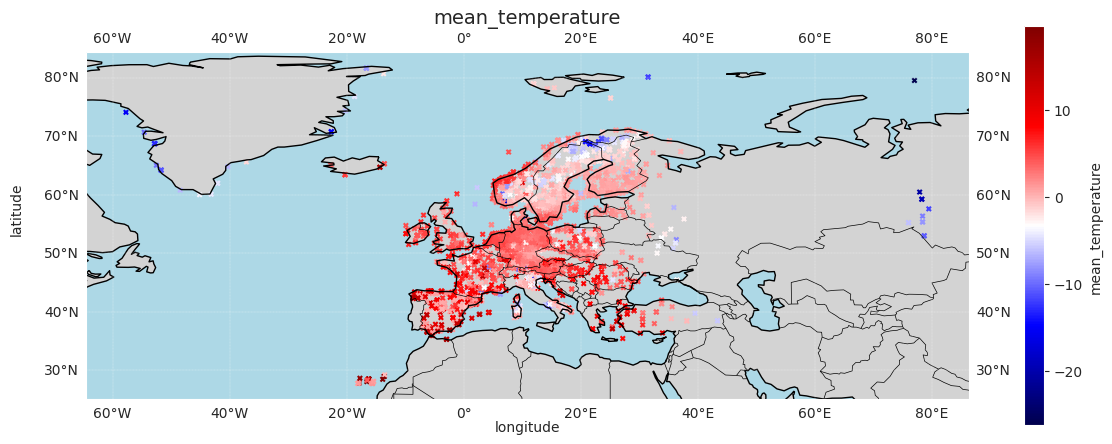

<GeoAxes: title={'center': 'mean_temperature'}>

In [4]:
train_dset = xr.open_dataset(TRAIN_DSET_PATH).cm.squeeze()
train_dset.plot()

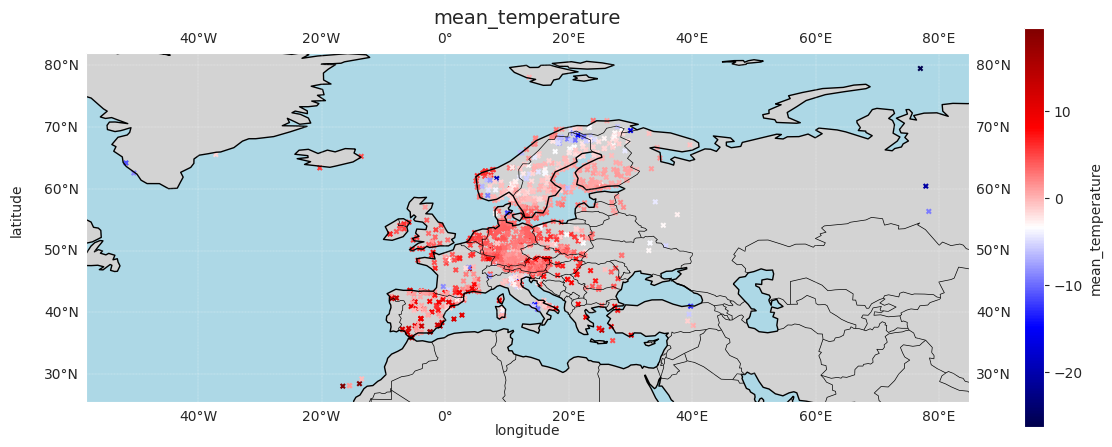

<GeoAxes: title={'center': 'mean_temperature'}>

In [5]:
val_dset = xr.open_dataset(VALIDATION_DSET_PATH).cm.squeeze()
val_dset.plot()

In [6]:
recon_dset = train_dset.reconstruct(
    val_dset.domain,
    method="idw",
)

In [7]:
def recon(train_dset, val_dset, **hparams) -> float:
    k_min = int(hparams["k_min"])
    k = int(hparams["k"])
    power = float(hparams["power"])
    if k_min > k:
        return -100
    recon_dset = train_dset.reconstruct(
        val_dset.domain,
        method="idw",
        k=k,
        power=power,
        k_min=k_min,
    )
    metrics = cm.Comparison(recon_dset, val_dset, map_nan_from_source=False).compute_report()
    # NOTE: minus to force maximizing
    return -metrics["Max Abs Error"]

In [8]:
bounds = {
    "k": (1, 50),
    "power": (1e-7, 5.0),
    "k_min": (1, 40),
}

In [9]:
result = find_hyperparameters(
    train_dset,
    val_dset,
    recon,
    bounds=bounds,
    n_init_points=OPTIM_INIT_POINTS,
    n_iter=OPTIM_N_ITERS,
    seed=SEED,
)

|   iter    |  target   |     k     |   k_min   |   power   |
-------------------------------------------------------------
| 1         | -100.0    | 21.43     | 29.09     | 0.000572  |
| 2         | -17.66    | 15.81     | 6.723     | 0.4617    |
| 3         | -100.0    | 10.13     | 14.48     | 1.984     |
| 4         | -22.54    | 27.4      | 17.35     | 3.426     |
| 5         | -100.0    | 11.02     | 35.25     | 0.1369    |
| 6         | -21.88    | 33.85     | 17.27     | 2.793     |
| 7         | -100.0    | 7.879     | 8.726     | 4.004     |
| 8         | -22.55    | 48.44     | 13.22     | 3.462     |
| 9         | -18.89    | 43.94     | 35.89     | 0.4252    |
| 10        | -100.0    | 2.914     | 7.623     | 4.391     |
| 11        | -100.0    | 5.819     | 17.42     | 4.789     |
| 12        | -19.07    | 27.13     | 27.98     | 1.578     |
| 13        | -19.03    | 34.64     | 33.55     | 0.09144   |
| 14        | -100.0    | 37.76     | 39.57     | 3.741     |
| 15    

In [10]:
optim_power = result['params']['power']
optim_k = result['params']['k']
optim_k_min = result['params']['k_min']

print("Power: ", optim_power, "K: ", optim_k, "K_min: ", optim_k_min)

Power:  0.03815589148301757 K:  11.657464939509213 K_min:  1.3549342724985132


In [11]:
res_dset = train_dset.reconstruct(
    val_dset.domain,
    method="idw",
    k=optim_k,
    power=optim_power,
    k_min=optim_k_min,
)

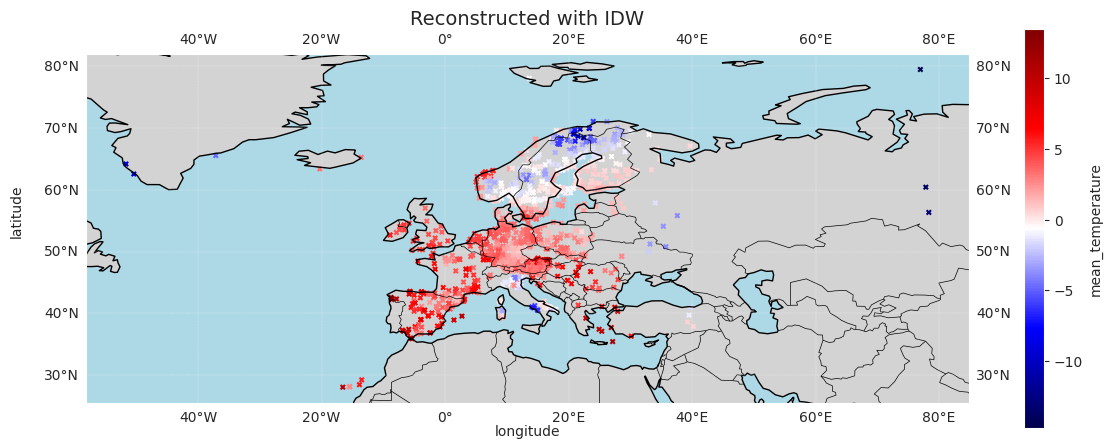

<GeoAxes: title={'center': 'Reconstructed with IDW'}>

In [12]:
res_dset.plot(title="Reconstructed with IDW")

In [13]:
cmp = cm.Comparison(res_dset, val_dset)

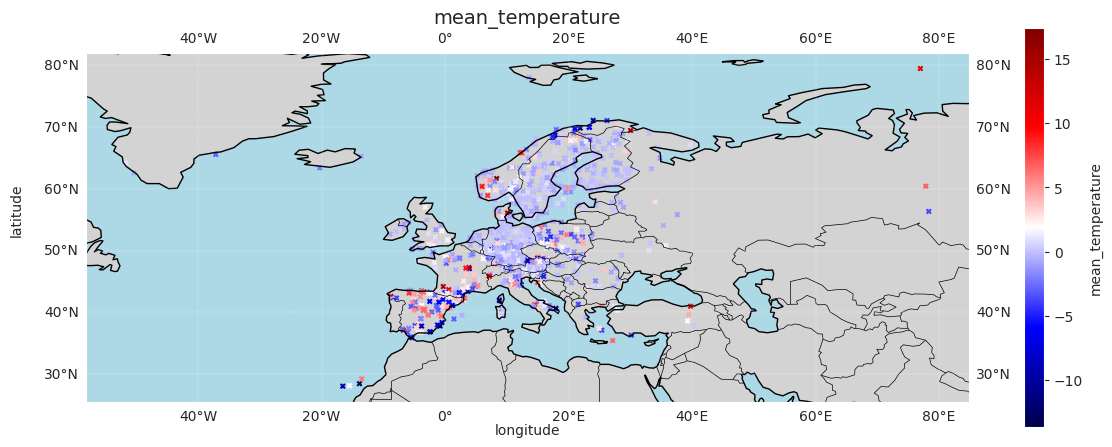

<GeoAxes: title={'center': 'mean_temperature'}>

In [14]:
cmp.plot_diff()

<Axes: >

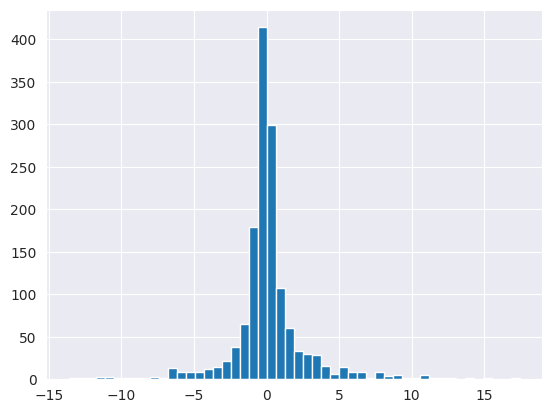

In [15]:
cmp.plot_signed_diff_hist()

In [17]:
cmp.compute_report()

{'RMSE': 2.699362040843048,
 'MAE': 1.4849305245964388,
 'Max Abs Error': 17.43584600775568,
 'R^2': 0.2741590153020025}